In [332]:
# Downloading PDFs
import requests
from bs4 import BeautifulSoup
import wget

# Data handling
import pandas as pd
import numpy as np
import datetime
import re

# Statistics
import statsmodels.tsa.x13 as sx13

# I/O
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import cm
%matplotlib inline

# Misc
import itertools

In [3]:
# set directory for files to be stored
DIR = "Data"
os.chdir(DIR)

### Reading and organizing data

In [246]:
''' Read in all tax data
Columns:
period - indicates yaer and quarter in format (YYYY Q[1-4])
original - non-seasonally adjusted value
adjusted - seasonally adjusted value*
state - indicates state with postal abbreviation. US denotes the total of all states except the District of Columbia.
category - indicates type of tax. Types included are:
    - Property 
    - General Sales and Gross Receipts 
    - Alcoholic Beverages Sales 
    - Amusements Sales 
    - Insurance Premiums Sales 
    - Motor Fuels Sales 
    - Pari-Mutuels Sales 
    - Public Utilities Sales 
    - Tobacco Products Sales 
    - Other Selective Sales and Gross Receipts 
    - Alcoholic Beverages License
    - Amusements License
    - Corporations in General License
    - Hunting and Fishing License
    - Motor Vehicles License
    - Motor Vehicles Operators License
    - Public Utilities License
    - Occupation and Business License
    - Other License 
    - Individual Income 
    - Corporation Net Income 
    - Death and Gift 
    - Documentary and Stock Transfer 
    - Severance 
    - Other Not Elsewhere Classified
    - Total 
    See dataset documentation for detail on category definitions.
    
*seasonally adjusted values obtained with X-13 SEATS procedure run with RJDMetra package in R. Used 
JDMetra 'RSA2c' preset specs: auto multiplicative/additive model detection; auto additive/level shift/temporary outlier detection;
trading day and Easter calendar effects (thinking was that they would affect sales/stock transfer/and possibly license taxes);
and the (0,1,1)(0,1,1) ARIMA model. 
'''

# Note: I did some initial data cleanup (e.g. renaming columns, deleting unneccessary columns, INDEX/MATCH-ing numerical keys
# with their corresponding English language values for ease of reference) in Excel. When I have some time I'll automate the
# data cleaning in pandas so new quarters can be added quickly.

file_path = "QTAX_adj.csv"
qtax_full = pd.read_csv(file_path, header = 0,parse_dates = [0])
qtax_full.category.replace('Other Not Elsewhere Classified','NEC',inplace = True)
qtax_full.category = qtax_full.category.apply(lambda x: x.replace(" ",""))








In [412]:
# State abbreviation dict to make switching between full name / abbr easier
state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'United States':'US'
}
# Geographic groupings
# Geographic regions other than the coasts going off of Bureau of Economic Analysis definitions. Top 15 are in terms 
# of population. Cities considered major are based on the top 6 most populous from Wikipedia: NYC, LA, Chicago, Houston,
# Phoenix, and Philadelphia.  
new_england = ['CT','ME','MA','NH','RI','VT']
mideast = ['DE','MD','NJ','NY','PA']
great_lakes = ['IL','IN','MI','OH','WI']
plains = ['IA','KS','MN','MO','NE','ND','SD']
south_east = ['AL','GA','VA','KY','TN','FL','LA','MS','SC','NC','AR','WV']
west_coast = ['CA','WA','OR']
east_coast = ['FL','GA','NC','SC','MD','NJ','NY','MA','CT','ME']
coast = west_coast + east_coast
far_west = west_coast + ['NV','HI','AK']
south_west = ['AZ','TX','NM','OK']
rocky_mountains = ['CO','ID','MN','UT','WY']

# Population groupings
top_15 = ['CA','TX','NY','FL','PA','IL','OH','GA','NC','NJ','MI','VA','WA','AZ','MA']
has_major_city = ['CA','NY','PA','AZ','TX']

# Economic groupings
high_gdp = ['CA','NY','TX','FL']

qtax_aug = pd.DataFrame(columns = ["period","original","adjusted","state","category","2q_ma","2q_gr"])    

# This takes a while to run because of the rolling mean calculation
for state in qtax_full.state.unique():
    for cat in qtax_full.category.unique():
        temp = qtax_full[qtax_full['state'] == state]
        temp = temp[temp['category'] == cat]
        temp['2q_ma'] = temp['adjusted'].rolling(window = 2).mean()
        temp['2q_gr'] = temp['2q_ma'].pct_change(periods = 2)
        qtax_aug = qtax_aug.append(temp)
qtax_aug.set_index('category',inplace = True)
        

In [419]:
all_states = [state for state in state_abbrev.values()]
all_states.remove('US')
all_states.remove('AK') # Excluding Alaska because extreme values mess up scale
no_gen_sales_tax = ['DE','MT','NH','OR']
no_personal_income_tax = ['FL','NV','SD','TX','WY','TN','NH'] # Including TN and NH because they don't tax wages,
# though they do tax investment income

## Helper functions

In [349]:
def abbrev(state):
    try:
        return us_state_abbrev[state]
    except:
        return state
    
def filter_data(category = 'Total', value = '2q_gr', states = 'all', melt = False):
    """Utility func to subset data by state group, tax category, metric in format expected by seaborn plotting
    methods. For heatmap, set melt = False. For lineplot, set melt = True."""
    data = qtax_aug.loc[category].pivot("period","state",value)
    if states != 'all':
        data = data[states]
    if melt:
        return data.reset_index().melt(id_vars = "period")
    else:
        data.index = data.index.to_period(freq = 'Q')
        return data
    
def growth_hmap(data,ax,title):
        sns.heatmap(data.transpose(), ax = ax, cmap = 'PiYG', xticklabels = 8, robust = True, center = 0)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title(title)

## 2Q growth rate heatmaps 

### Total tax revenue

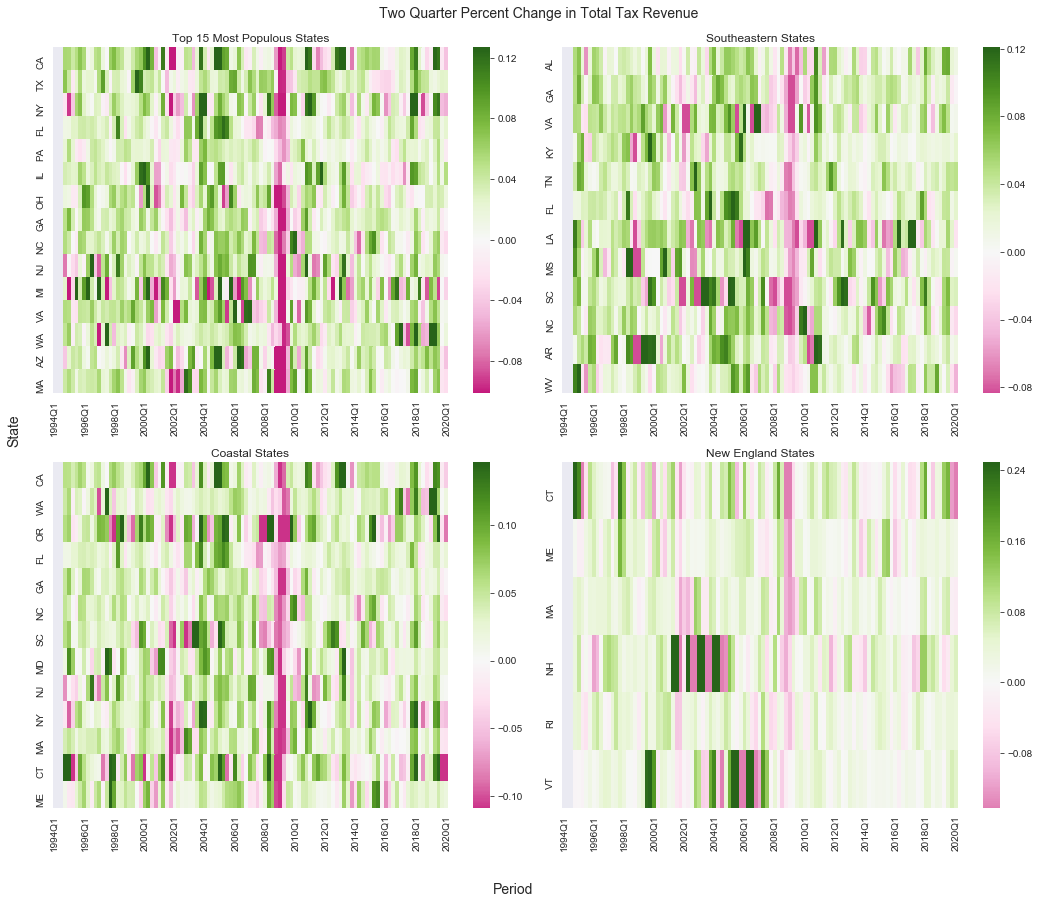

In [533]:
# 2q growth rate for most populous states and selected regions
fig, axs = plt.subplots(2,2, figsize=(18,14))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

# 15 most populous
growth_hmap(filter_data(states = top_15),ul,"Top 15 Most Populous States")

# Southeast
growth_hmap(filter_data(states = south_east),ur,"Southeastern States")

# Coasts
growth_hmap(filter_data(states = coast),ll,"Coastal States")

# States with major cities
growth_hmap(filter_data(states = new_england),lr,"New England States")

fig.suptitle("Two Quarter Percent Change in Total Tax Revenue", fontsize = 14, y = .92)
fig.subplots_adjust(wspace=0.03)
fig.text(0.48, 0.04, 'Period', fontsize = 14, ha='center')
fig.text(0.09, 0.5, 'State', va='center', fontsize = 14, rotation='vertical')
plt.savefig("Total_GR.png")
plt.show()

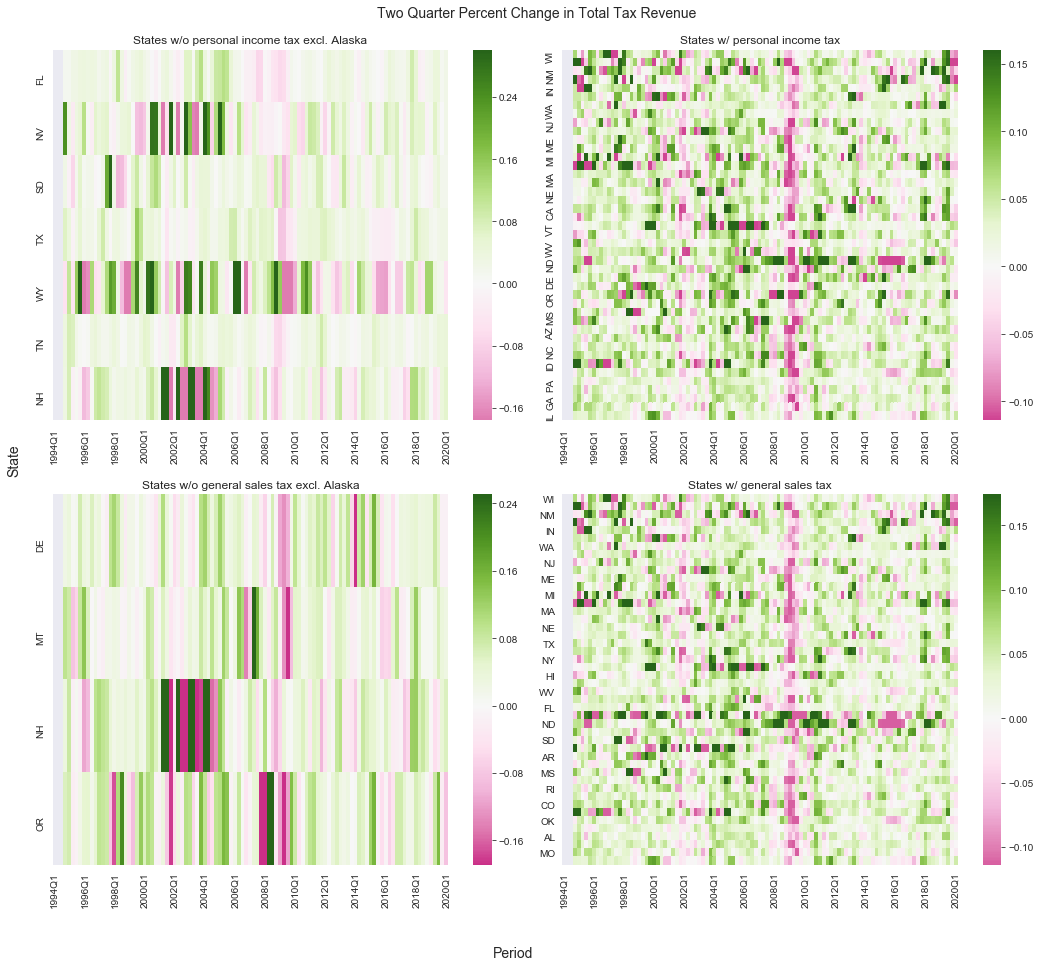

In [532]:
# 2q growth rate for different tax structures
fig, axs = plt.subplots(2,2, figsize=(18,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

# No income tax
growth_hmap(filter_data(states = no_personal_income_tax),ul,"States w/o personal income tax excl. Alaska")

# Income tax
growth_hmap(filter_data(states = list(set(all_states) - set(no_personal_income_tax))),
            ur,"States w/ personal income tax")

# No general sales tax
growth_hmap(filter_data(states = no_gen_sales_tax),ll,"States w/o general sales tax excl. Alaska")

# General sales tax
growth_hmap(filter_data(states = list(set(all_states) - set(no_gen_sales_tax))),
            lr,"States w/ general sales tax")

fig.suptitle("Two Quarter Percent Change in Total Tax Revenue ", fontsize = 14, y = .92)
fig.subplots_adjust(wspace=0.03)
fig.text(0.48, 0.04, 'Period', fontsize = 14, ha='center')
fig.text(0.09, 0.5, 'State', va='center', fontsize = 14, rotation='vertical')
plt.savefig("Total_GR_by_Tax_Struct.png")
plt.show()

### Sales tax revenue`

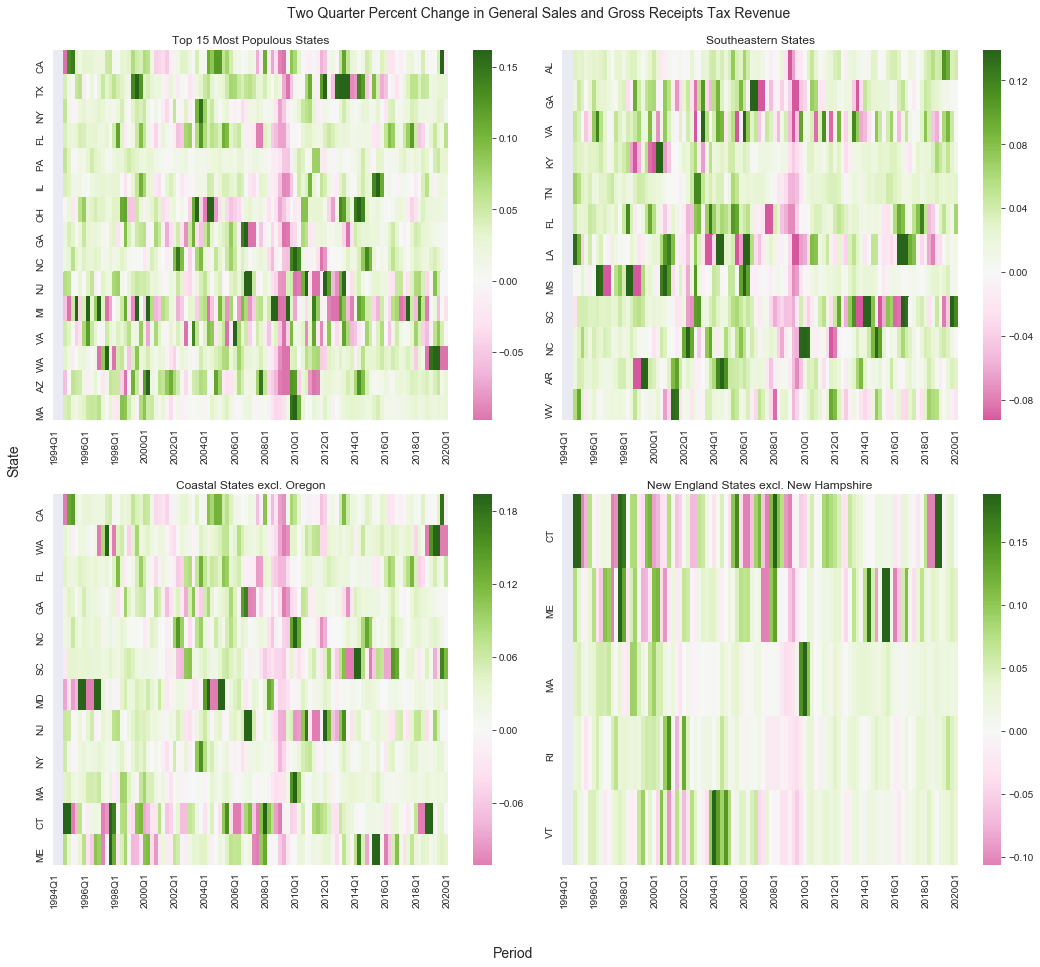

In [531]:
fig, axs = plt.subplots(2,2, figsize=(18,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]
cat = 'GeneralSalesandGrossReceipts'
coast_ed = list(coast)
coast_ed.remove('OR') # Oregon doesn't have a general sales tax
new_england_ed = list(new_england)
new_england_ed.remove('NH') # New Hampshire doesn't have a general sales tax
# 15 most populous
growth_hmap(filter_data(category = cat, states = top_15),ul,"Top 15 Most Populous States")

# Southeast
growth_hmap(filter_data(category = cat, states = south_east),ur,"Southeastern States")

# Coasts
growth_hmap(filter_data(category = cat, states = coast_ed),ll,"Coastal States excl. Oregon")

# States with major cities
growth_hmap(filter_data(category = cat, states = new_england_ed),lr,"New England States excl. New Hampshire")

fig.suptitle("Two Quarter Percent Change in General Sales and Gross Receipts Tax Revenue", fontsize = 14, y = .92)
fig.subplots_adjust(wspace=0.03)
fig.text(0.48, 0.04, 'Period', fontsize = 14, ha='center')
fig.text(0.09, 0.5, 'State', va='center', fontsize = 14, rotation='vertical')
plt.savefig("Sales_GR.png")
plt.show()

### Corporate income tax revenue

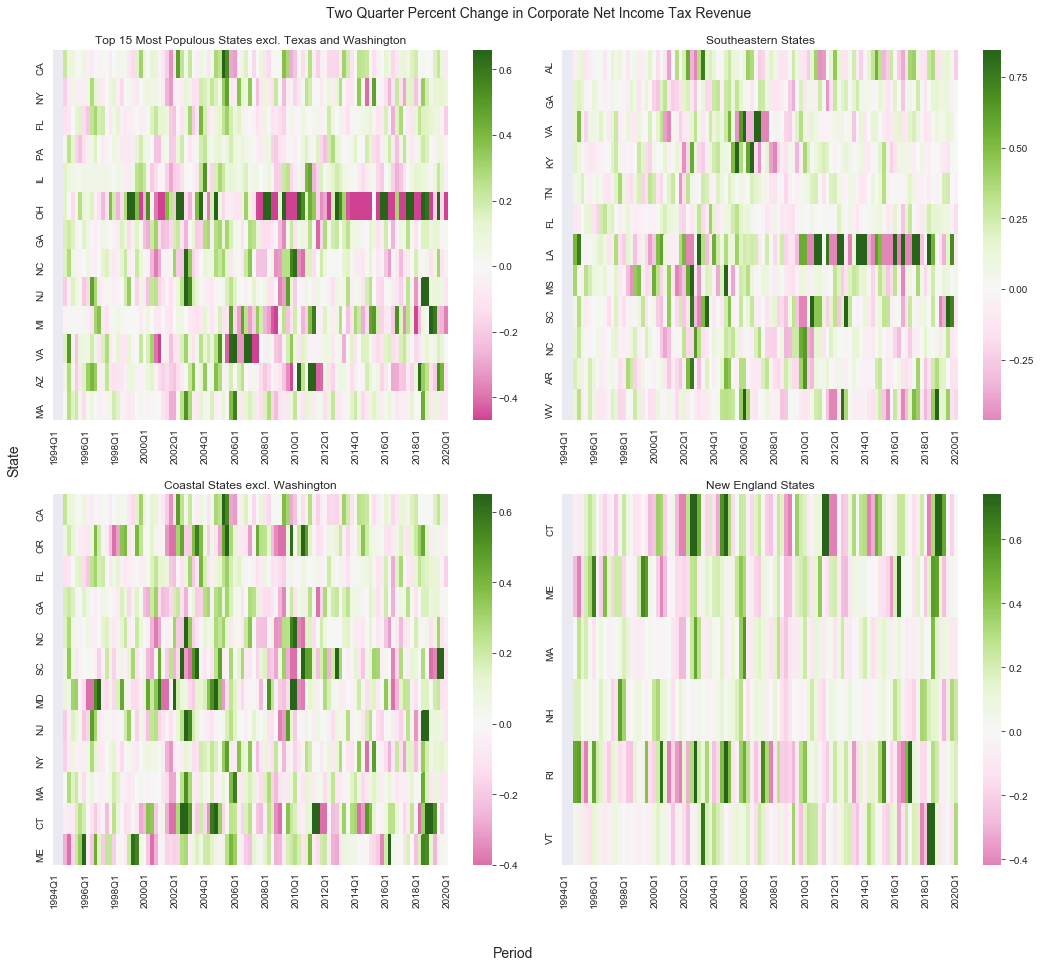

In [530]:
fig, axs = plt.subplots(2,2, figsize=(18,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]
cat = 'CorporationNetIncome'
# Washington and Texas don't have a corporate net income tax
coast_ed = list(coast)
coast_ed.remove('WA') 
new_england_ed = list(new_england)
top_15_ed = list(top_15)
top_15_ed.remove('TX')
top_15_ed.remove('WA')
# 15 most populous
growth_hmap(filter_data(category = cat, states = top_15_ed),ul,"Top 15 Most Populous States excl. Texas and Washington")

# Southeast
growth_hmap(filter_data(category = cat, states = south_east),ur,"Southeastern States")

# Coasts
growth_hmap(filter_data(category = cat, states = coast_ed),ll,"Coastal States excl. Washington")

# States with major cities
growth_hmap(filter_data(category = cat, states = new_england_ed),lr,"New England States")

fig.suptitle("Two Quarter Percent Change in Corporate Net Income Tax Revenue", fontsize = 14, y = .92)
fig.subplots_adjust(wspace=0.03)
fig.text(0.48, 0.04, 'Period', fontsize = 14, ha='center')
fig.text(0.09, 0.5, 'State', va='center', fontsize = 14, rotation='vertical')
plt.savefig("Corporate_Income_GR.png")
plt.show()

Notes:
* Outlier in Washington state during 1997, anomalous dip and spike. Attributable to volatile general
   sales and use taxes. Rate increases were approved in metro area for football stadium construction and new transi      system, also internet boom contributed to large sales tax increase.
* Outlier in California in 2005
* Florida revenue smoothest through recession (though decline begins earlier)
* States with severe dips in 2001-2002 also have severe dips in 2008-2009.

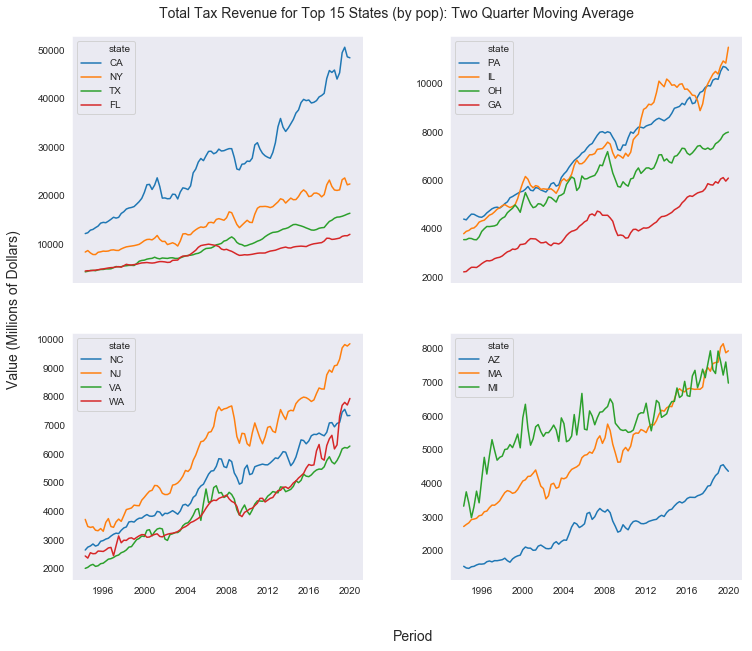

In [529]:
# Line plots
sns.set_style("dark")
fig, axs = plt.subplots(2,2,figsize=(12,10),sharex = True)
group1 = ['CA','NY','TX','FL']
group2 = ['PA','IL','OH','GA']
group3 = ['NC','NJ','VA','WA']
group4 = ['AZ','MA','MI']
cat = 'Total'
val = '2q_ma'
sns.lineplot(x = "period", y = "value", data = filter_data(category = cat, value = val,
                                                           states = group1, melt = True), hue = "state",ax = axs[0,0])
sns.lineplot(x = "period", y = "value", data = filter_data(category = cat, value = val,
                                                           states = group2, melt = True), hue = "state",ax = axs[0,1])
sns.lineplot(x = "period", y = "value", data = filter_data(category = cat, value = val,
                                                           states = group3, melt = True), hue = "state",ax = axs[1,0])
sns.lineplot(x = "period", y = "value", data = filter_data(category = cat, value = val,
                                                    states = group4, melt = True), hue = "state",ax = axs[1,1])
for ax in axs.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.suptitle("Total Tax Revenue for Top 15 States (by pop): Two Quarter Moving Average", fontsize = 14, y = .92)
fig.subplots_adjust(wspace=0.3)
fig.text(0.52, 0.04, 'Period', fontsize = 14, ha='center')
fig.text(0.05, 0.5, 'Value (Millions of Dollars)', va='center', fontsize = 14, rotation='vertical')
plt.savefig("Total_MA_Top_15_States.png")
plt.show()

## Individual state profiles

### California

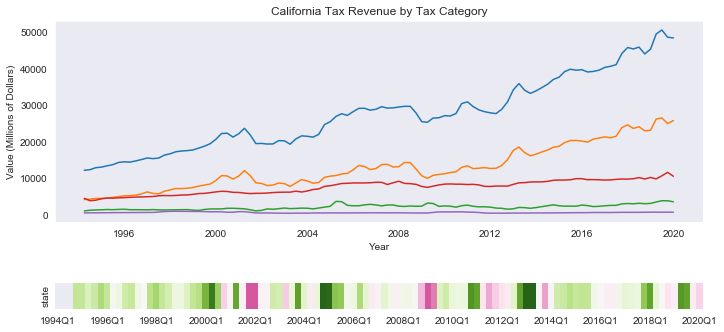

In [518]:
left = 0.1
width = 1.5
ax1 = plt.axes([left, 0.5, width, .7])
ax2 = plt.axes([left, 0.2, width, 0.09])
state = ['CA']
val = '2q_ma'

# Plot moving averages for select taxes on top 
sns.lineplot(x = 'period', y = 'value', data = filter_data(category = 'Total',states = state, value = val, melt = True),
            ax = ax1)
sns.lineplot(x = 'period', y = 'value', data = filter_data(category = 'IndividualIncome',states = state, value = val, melt = True),
            ax = ax1)
sns.lineplot(x = 'period', y = 'value', data = filter_data(category = 'CorporationNetIncome',states = state, value = val, melt = True),
            ax = ax1)
sns.lineplot(x = 'period', y = 'value', data = filter_data(category = 'GeneralSalesandGrossReceipts',states = state, value = val, melt = True),
            ax = ax1)
sns.lineplot(x = 'period', y = 'value', data = filter_data(category = 'Property',states = state, value = val, melt = True),
            ax = ax1)
ax1.set_xlabel("Year")
ax1.set_ylabel("Value (Millions of Dollars)")
ax1.set_title("California Tax Revenue by Tax Category")
# Plot total tax growth rate
ax = ax2
data = filter_data(states = state)
sns.heatmap(data.transpose(), ax = ax, cmap = 'PiYG', xticklabels = 8, robust = True, center = 0,cbar = False,
           yticklabels=False)
ax.set_xlabel("")
plt.show()


In [267]:
# Add some unemployment data (from FRED via BLS)

unemployment = pd.read_csv("Data/Unemployment/state_unemployment.txt", sep = "\t",header = 0, parse_dates = [0])

In [268]:
unemployment.head()

,DATE,AZ,CA,FL
0,2003-10-01,9.9,11.7,9.3
1,2004-01-01,9.7,11.6,9.1
2,2004-04-01,9.6,11.4,9.0
3,2004-07-01,9.1,11.2,8.6
4,2004-10-01,9.2,11.0,8.3


In [ ]:
# June 23 - July 1 To-Do
# go through annual survey for state / local revenue breakdown. Which states are more self sufficient versus which 
# dependent on particular localities. Some volatility because most stuff at local level. 
# What does local revenue look like. Which parts are more cyclical, less cyclical? Impute from annual survey about local 
# tax revenue. 
# Look at cyclical patterns with localities and states. Probably ok at annual level, need quarterly updating process
# Want to quickly anticipate revenue, on a quarterly basis
# LAUS unemployment statistics from FRED (State abbrev + UR)
# FRED payroll unemployment data

In [527]:
os.getcwd()

'/Users/becca/Documents/Employ America/qtax/Data'

In [169]:
"""Import local and state annual survey data
Source: U.S. Census Bureau, Annual Survey of State and Local Government Finances and Census of Governments (1977-2017) 
via the State and Local Finance Data Query System, Urban-Brookings Tax Policy Center

2001 and 2003 missing because sample design during those years only allowed national level estimates. 
"""
columns = ["State", 
          "Year",
          "TotalTaxes",
          "Property",
           "NonProperty",
           "SalesAndGrossReceipts",
           "GeneralSales",
           "SelectSales",
           "AlcoholicBeverageSales",
           "AmusementsSales",
           "InsurancePremiumSales",
           "MotorFuelsSales",
           "ParimutuelsSales",
           "PublicUtilitySales",
           "TobaccoSales",
           "OtherSelectSales",
           "TotalLicense",
           "AlcoholicBeverageLicense",
           "CorporationLicense",
           "MotorVehicleAndOperatorLicense",
           "MotorVehicleLicense",
           "MotorVehicleOperatorLicense",
           "OtherLicnese",
           "TotalIncome",
           "IndividualIncome",
           "CorporateNetIncome",
           "DeathAndGift",
           "NEC"
          ]

local_annual_survey = pd.read_csv("Annual Surveys/local_annual_survey.csv",skiprows = 3, names = columns, parse_dates = [1])
combined_annual_survey = pd.read_csv("Annual Surveys/combined_annual_survey.csv",skiprows = 3,
                                     names = columns, parse_dates = [1])
#combined_annual_survey.dropna(axis=0,inplace = True)
for df in [local_annual_survey,combined_annual_survey]:
    df.drop("NEC", axis = 1, inplace = True)
    df.dropna(axis = 0, inplace = True)
    df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x.str.replace("$",""))
    df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x.str.replace(",","")).astype(float)
    df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x/1000)
    df['State'] = df['State'].apply(lambda x: abbrev(x))

In [221]:
# Percent of total state tax revenue from local tax revenue
local_totals = local_annual_survey.pivot("Year","State","TotalTaxes")
combined_totals = combined_annual_survey.pivot("Year","State","TotalTaxes")
percent_local = local_totals.div(combined_totals)
percent_local.drop(["US","DC"],axis=1,inplace = True)
percent_local.interpolate(method = "linear",inplace = True)
#percent_local.reset_index(inplace = True)

In [153]:
#percent_local = percent_local.melt("Year")

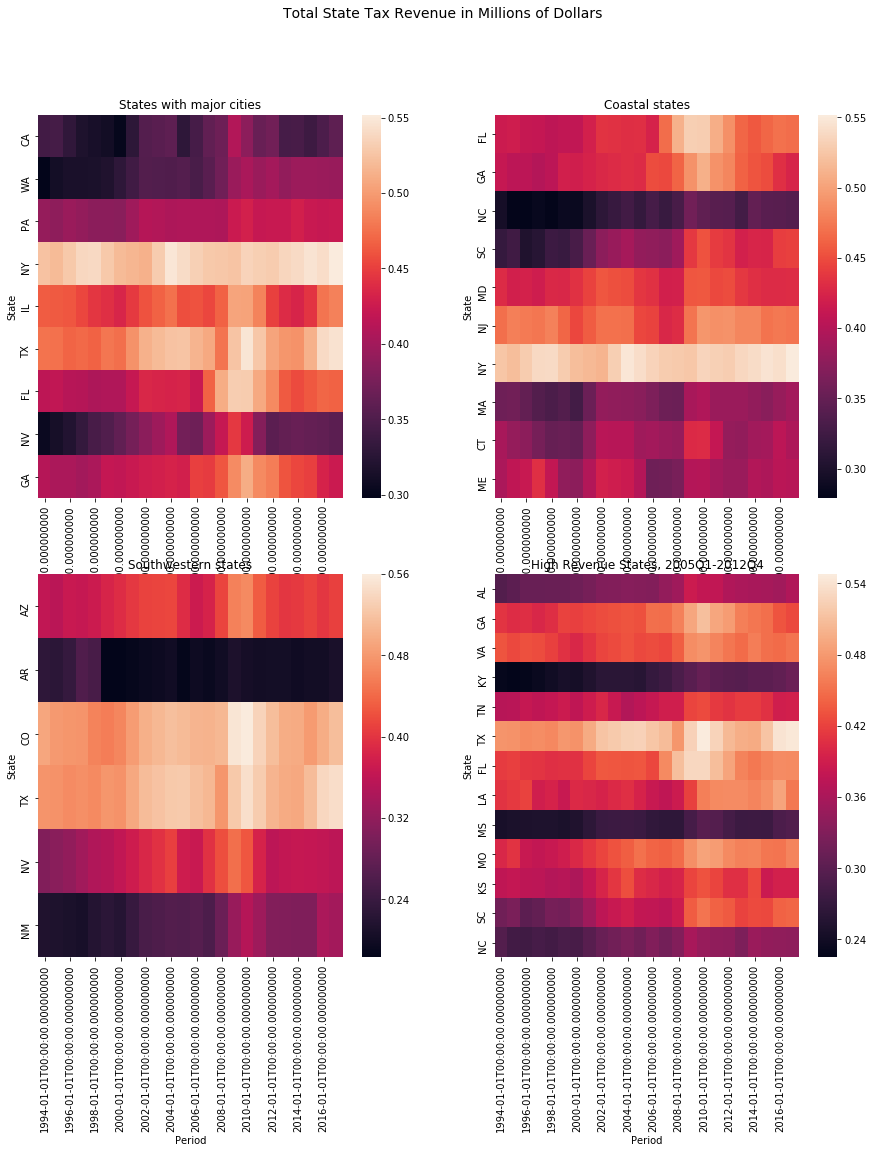

In [237]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]
date_format = DateFormatter('%Y')

#states with major cities
sns.heatmap(percent_local[has_major_city].transpose(),ax = ul,xticklabels = 2)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("States with major cities")
#ul.xaxis_date()
#ul.xaxis.set_major_formatter(date_format)
plt.subplots_adjust(bottom=.1)

# east coast states
sns.heatmap(percent_local[east_coast].transpose(),ax = ur,xticklabels = 2)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("Coastal states")

# southwestern states
sns.heatmap(percent_local[south_west].transpose(),ax = ll,xticklabels = 2)
ll.set_ylabel("State")
ll.set_xlabel("Period")
ll.set_title("Southwestern states")

# S=southern states
sns.heatmap(percent_local[south].transpose(),
            ax = lr,xticklabels = 2)
lr.set_ylabel("State")
lr.set_xlabel("Period")
lr.set_title("Southern states, 2005Q1-2012Q4")
fig.suptitle("Local ",fontsize=14)
plt.show()

In [ ]:
# Red to white to green
# Separate time series charts clean up a bit
# Which states have more cyclical revenue
# Rolling semi-annualized - 2 quarter rolling average then 2 quarter growth rate